# EDA

In [399]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from  nltk import FreqDist

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from mlxtend.feature_selection import ColumnSelector
from sklearn.feature_selection import chi2

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from sklearn.model_selection import train_test_split
import re
import string

In [400]:
df = pd.read_pickle("../data/df.pkl")
df.head()

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left


In [5]:
df.shape

(85365, 3)

In [6]:
df.isna().sum()

Publication    0
Content        1
Bias           0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

Publication    0
Content        0
Bias           0
dtype: int64

In [9]:
df.info

<bound method DataFrame.info of            Publication                                            Content  \
0                  CNN  Istanbul (CNN) At least 39 people were killed ...   
1                  CNN  Atlanta (CNN) This season’s College Football P...   
2                  CNN   (CNN) Revelers on the United States’ west coa...   
3                  CNN  West Palm Beach, Florida (CNN)  Donald Trump s...   
4                  CNN   (CNN) Two small planes collided in Texas on S...   
...                ...                                                ...   
85360  National Review  I first read Thomas Sowell in college  —   no ...   
85361  National Review  Whether it’s celebrated according to the Grego...   
85362  National Review  Editor’s Note: This piece first appeared in th...   
85363  National Review  Israel would seem to be in a disastrous positi...   
85364  National Review  The year 2016 was a good one for books by men ...   

        Bias  
0       Left  
1       Left 

In [10]:
df["Publication"].value_counts()

Breitbart          23781
The Hill           16811
Vox                16371
CNN                11488
Reuters            10710
National Review     6203
Name: Publication, dtype: int64

In [11]:
df["Bias"].value_counts()

Right     29984
Left      27859
Center    27521
Name: Bias, dtype: int64

In [12]:
print("Percentage of Articles per Bias in Dataset:")
df["Bias"].value_counts(normalize=True)*100

Percentage of Articles per Bias in Dataset:


Right     35.124877
Left      32.635537
Center    32.239586
Name: Bias, dtype: float64

In [13]:
def countplot(df, col, hue=None, rotation=None, order=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue, order = order)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of articles", fontsize = 20)
    ax.set_title(f"Number of articles per {col}", fontsize = 30)
    plt.show()

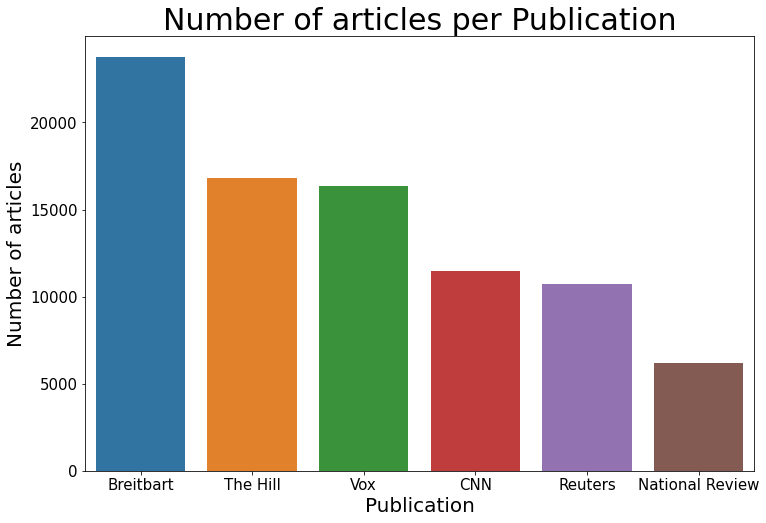

In [14]:
countplot(df, "Publication", order = df["Publication"].value_counts().index)

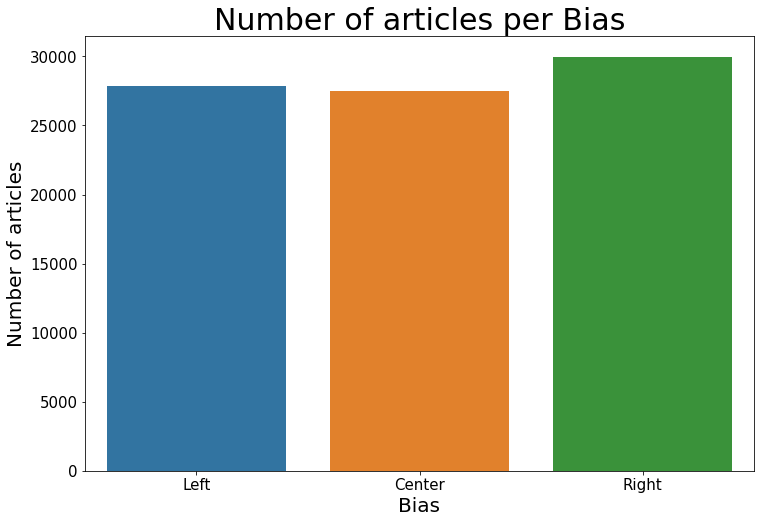

In [15]:
countplot(df, "Bias", order = ["Left", "Center", "Right"])

In [16]:
df_plot = df.groupby(['Publication', 'Bias']).size().reset_index().pivot(columns='Publication', index='Bias', values=0)

In [17]:
df_plot = df_plot.reindex(["Left", "Center", "Right"])

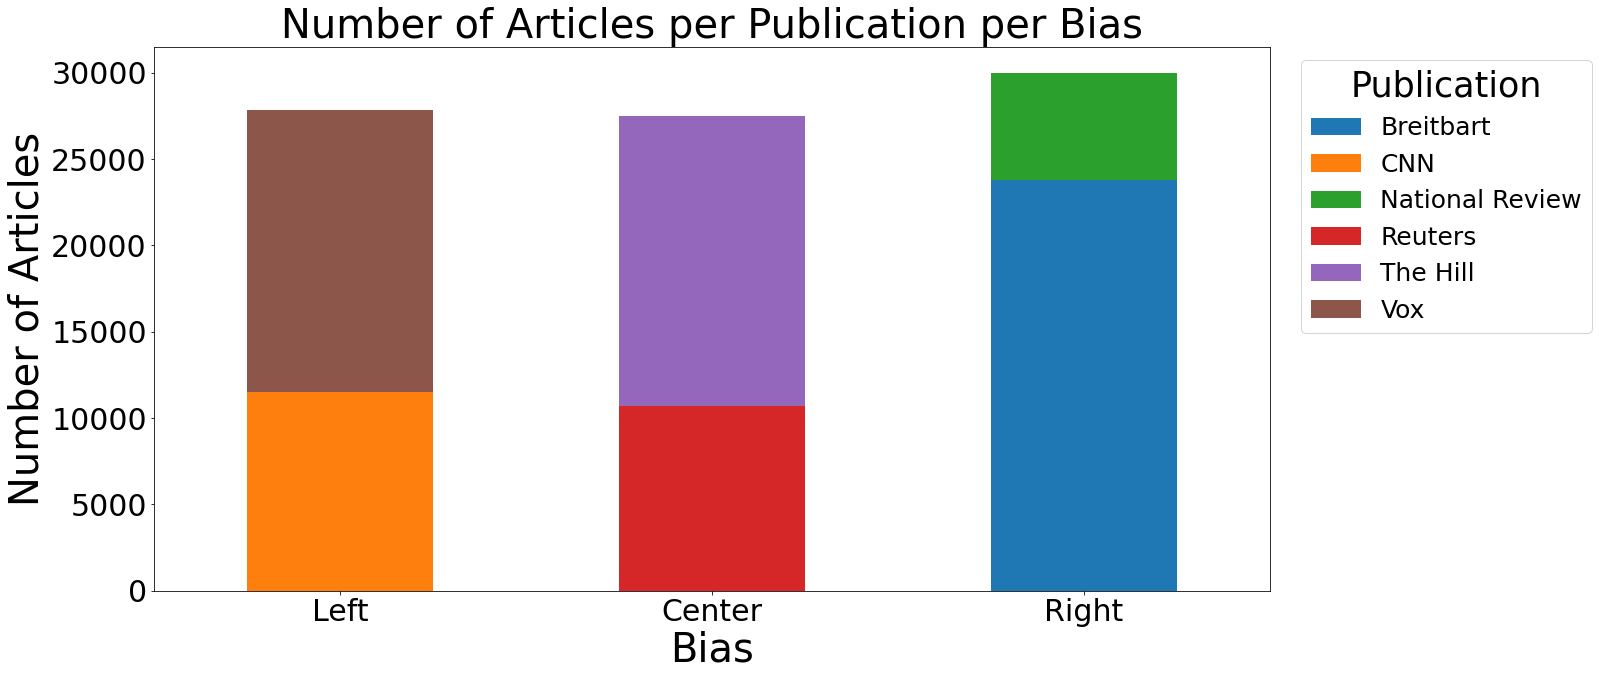

In [18]:
df_plot.plot(kind='bar', stacked=True, figsize=(20,10))
plt.xticks(rotation="horizontal", fontsize = 30)
plt.xlabel(xlabel = "Bias", fontsize = 40)
plt.yticks(rotation="horizontal", fontsize = 30)
plt.ylabel(ylabel = "Number of Articles", fontsize = 40)
plt.title(label= "Number of Articles per Publication per Bias", fontsize = 40)
plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", ncol=1, fontsize= 25, title = "Publication", title_fontsize= 35)
plt.show()

In [401]:
df

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left
...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right
85361,National Review,Whether it’s celebrated according to the Grego...,Right
85362,National Review,Editor’s Note: This piece first appeared in th...,Right
85363,National Review,Israel would seem to be in a disastrous positi...,Right


In [402]:
df['word_count'] = df["Content"].apply(lambda x: len(nltk.word_tokenize(str(x))) )
df['char_count'] = df["Content"].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
df['sentence_count'] = df["Content"].apply(lambda x: len(nltk.sent_tokenize(str(x))) )

KeyboardInterrupt: 

In [ ]:
df

# Preprocessing Data

In [19]:
df

,Publication,Content,Bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left
1,CNN,Atlanta (CNN) This season’s College Football P...,Left
2,CNN,(CNN) Revelers on the United States’ west coa...,Left
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left
4,CNN,(CNN) Two small planes collided in Texas on S...,Left
...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right
85361,National Review,Whether it’s celebrated according to the Grego...,Right
85362,National Review,Editor’s Note: This piece first appeared in th...,Right
85363,National Review,Israel would seem to be in a disastrous positi...,Right


In [371]:
#If we did a multi class
dict_sent = {'Left':0, 
             'Center':1,
             'Right':2}
df["num_bias"] = df["Bias"].map(dict_sent)

In [372]:
df.head()

,Publication,Content,Bias,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,0,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,0,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,0,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,0,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,0,two small plane collided texas saturday killin...


In [373]:
df.iloc[45000:45005]

,Publication,Content,Bias,num_bias,processed_content
45001,The Hill,Rep. Al GreenAlexander (Al) N. GreenWe need a ...,Center,1,rep al greenalexander al greenwe need climate ...
45002,The Hill,View the discussion thread. The Hill 1625 K St...,Center,1,
45003,The Hill,Rep. Al GreenAlexander (Al) N. GreenWe need a ...,Center,1,rep al greenalexander al greenwe need climate ...
45004,The Hill,The public health community has been closely w...,Center,1,public health community closely watching propo...
45005,The Hill,One of the contributing factors that led to Do...,Center,1,one contributing factor led donald trump elect...


In [374]:
df.tail()

,Publication,Content,Bias,num_bias,processed_content
85360,National Review,I first read Thomas Sowell in college — no ...,Right,2,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,2,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,2,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,2,israel would seem disastrous position given in...
85364,National Review,The year 2016 was a good one for books by men ...,Right,2,year good one book men named yuval past year r...


In [277]:
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")
lemma = WordNetLemmatizer()

In [278]:
source = list(df["Publication"].unique())
source = (map(lambda x: x.lower(), source))
source = list(source)
source

['cnn', 'vox', 'reuters', 'the hill', 'breitbart', 'national review']

In [279]:
stopwords_list = stopwords.words("english")
stopwords_list += string.punctuation
stopwords_list += source
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [28]:
nums = [i for i in range(10)]
nums

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [261]:
test = df["Content"].iloc[random.randint(0,df.shape[0])]
test

'Rock band Papa Roach took a swing at Paul RyanPaul  Davis RyanEmbattled Juul seeks allies in Washington Ex-Parkland students criticize Kellyanne Conway Latina leaders: \'It\'s a women\'s world more than anything\' MORE on Twitter after being the butt of a social media joke about the House Speaker. A viral meme late Friday imagined a phony New York Times report that Ryan was heard listening to Papa Roach\'s 2000 hit "Last Resort" as he drove away from the White House after the GOP\'s healthcare bill was pulled from the floor in the face of certain failure. The original tweet, by comedian Justin Halpern, echoed throughout Twitter, unleashing a torrent of Papa Roach references and jokes about Ryan\'s musical taste. Some on social media were even confused over whether it was a real New York Times report. ooof the kicker on this New York Times story...\xa0pic.twitter.com/YO6Wq3k5vK Halpern later tweeted: "I honestly thought my Paul Ryan/ Papa Roach photoshop joke was obvious," decrying the

In [263]:
test = test.lower()

In [262]:
pattern = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))"
pattern1 =  "((the views expressed by)([\s\S]*)$)"
pattern2 = "([\d.])"
pattern3 = "(http\S+)"
pattern4 = "((view the discussion thread.)([\s\S]*)$)"
pattern5 = "((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?)"

In [ ]:
 ((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?) | \
                ([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)|((view the discussion thread.)([\s\S]*)$)|\
                ((the views expressed by contributors are their own and not the views of the hill.)([\s\S]*)$)|(http\S+)|([\d.])

In [264]:
test = re.sub(pattern,"", test)
test

'rock band papa roach took a swing at paul ryanpaul  davis ryanembattled juul seeks allies in washington ex-parkland students criticize kellyanne conway latina leaders: \'it\'s a women\'s world more than anything\' more on twitter after being the butt of a social media joke about the house speaker. a viral meme late friday imagined a phony new york times report that ryan was heard listening to papa roach\'s 2000 hit "last resort" as he drove away from the white house after the gop\'s healthcare bill was pulled from the floor in the face of certain failure. the original tweet, by comedian justin halpern, echoed throughout twitter, unleashing a torrent of papa roach references and jokes about ryan\'s musical taste. some on social media were even confused over whether it was a real new york times report. ooof the kicker on this new york times story...\xa0pic.twitter.com/yo6wq3k5vk halpern later tweeted: "i honestly thought my paul ryan/ papa roach photoshop joke was obvious," decrying the

In [265]:
test =  re.sub(pattern1,"", test)
test

'rock band papa roach took a swing at paul ryanpaul  davis ryanembattled juul seeks allies in washington ex-parkland students criticize kellyanne conway latina leaders: \'it\'s a women\'s world more than anything\' more on twitter after being the butt of a social media joke about the house speaker. a viral meme late friday imagined a phony new york times report that ryan was heard listening to papa roach\'s 2000 hit "last resort" as he drove away from the white house after the gop\'s healthcare bill was pulled from the floor in the face of certain failure. the original tweet, by comedian justin halpern, echoed throughout twitter, unleashing a torrent of papa roach references and jokes about ryan\'s musical taste. some on social media were even confused over whether it was a real new york times report. ooof the kicker on this new york times story...\xa0pic.twitter.com/yo6wq3k5vk halpern later tweeted: "i honestly thought my paul ryan/ papa roach photoshop joke was obvious," decrying the

In [266]:
test =  re.sub(pattern5,"", test)
test

'rock band papa roach took a swing at paul ryanpaul  davis ryanembattled juul seeks allies in washington ex-parkland students criticize kellyanne conway latina leaders: \'it\'s a women\'s world more than anything\' more on twitter after being the butt of a social media joke about the house speaker. a viral meme late friday imagined a phony new york times report that ryan was heard listening to papa roach\'s 2000 hit "last resort" as he drove away from the white house after the gop\'s healthcare bill was pulled from the floor in the face of certain failure. the original tweet, by comedian justin halpern, echoed throughout twitter, unleashing a torrent of papa roach references and jokes about ryan\'s musical taste. some on social media were even confused over whether it was a real new york times report. ooof the kicker on this new york times story...\xa0 halpern later tweeted: "i honestly thought my paul ryan/ papa roach photoshop joke was obvious," decrying the confusion over it\'s legi

In [267]:
test =  re.sub(pattern2,"", test)
test

'rock band papa roach took a swing at paul ryanpaul  davis ryanembattled juul seeks allies in washington ex-parkland students criticize kellyanne conway latina leaders: \'it\'s a women\'s world more than anything\' more on twitter after being the butt of a social media joke about the house speaker a viral meme late friday imagined a phony new york times report that ryan was heard listening to papa roach\'s  hit "last resort" as he drove away from the white house after the gop\'s healthcare bill was pulled from the floor in the face of certain failure the original tweet, by comedian justin halpern, echoed throughout twitter, unleashing a torrent of papa roach references and jokes about ryan\'s musical taste some on social media were even confused over whether it was a real new york times report ooof the kicker on this new york times story\xa0 halpern later tweeted: "i honestly thought my paul ryan/ papa roach photoshop joke was obvious," decrying the confusion over it\'s legitimacy\xa0 

In [268]:
test =  re.sub(pattern3,"", test)
test

'rock band papa roach took a swing at paul ryanpaul  davis ryanembattled juul seeks allies in washington ex-parkland students criticize kellyanne conway latina leaders: \'it\'s a women\'s world more than anything\' more on twitter after being the butt of a social media joke about the house speaker a viral meme late friday imagined a phony new york times report that ryan was heard listening to papa roach\'s  hit "last resort" as he drove away from the white house after the gop\'s healthcare bill was pulled from the floor in the face of certain failure the original tweet, by comedian justin halpern, echoed throughout twitter, unleashing a torrent of papa roach references and jokes about ryan\'s musical taste some on social media were even confused over whether it was a real new york times report ooof the kicker on this new york times story\xa0 halpern later tweeted: "i honestly thought my paul ryan/ papa roach photoshop joke was obvious," decrying the confusion over it\'s legitimacy\xa0 

In [269]:
test =  re.sub(pattern4,"", test)
test

'rock band papa roach took a swing at paul ryanpaul  davis ryanembattled juul seeks allies in washington ex-parkland students criticize kellyanne conway latina leaders: \'it\'s a women\'s world more than anything\' more on twitter after being the butt of a social media joke about the house speaker a viral meme late friday imagined a phony new york times report that ryan was heard listening to papa roach\'s  hit "last resort" as he drove away from the white house after the gop\'s healthcare bill was pulled from the floor in the face of certain failure the original tweet, by comedian justin halpern, echoed throughout twitter, unleashing a torrent of papa roach references and jokes about ryan\'s musical taste some on social media were even confused over whether it was a real new york times report ooof the kicker on this new york times story\xa0 halpern later tweeted: "i honestly thought my paul ryan/ papa roach photoshop joke was obvious," decrying the confusion over it\'s legitimacy\xa0 

In [270]:
test =  re.sub(pattern5,"", test)
test

'rock band papa roach took a swing at paul ryanpaul  davis ryanembattled juul seeks allies in washington ex-parkland students criticize kellyanne conway latina leaders: \'it\'s a women\'s world more than anything\' more on twitter after being the butt of a social media joke about the house speaker a viral meme late friday imagined a phony new york times report that ryan was heard listening to papa roach\'s  hit "last resort" as he drove away from the white house after the gop\'s healthcare bill was pulled from the floor in the face of certain failure the original tweet, by comedian justin halpern, echoed throughout twitter, unleashing a torrent of papa roach references and jokes about ryan\'s musical taste some on social media were even confused over whether it was a real new york times report ooof the kicker on this new york times story\xa0 halpern later tweeted: "i honestly thought my paul ryan/ papa roach photoshop joke was obvious," decrying the confusion over it\'s legitimacy\xa0 

In [70]:
# test = test.lower()
# test

In [71]:
test = tokenizer.tokenize(test)
test

['cnn',
 'hugh',
 'hefner',
 'playboy',
 'mansion',
 'was',
 'gilded',
 'cage',
 'for',
 'former',
 'hef',
 'companion',
 'holly',
 'madison',
 'in',
 'her',
 'new',
 'memoir',
 'down',
 'the',
 'rabbit',
 'hole',
 'madison',
 'one',
 'of',
 'the',
 'stars',
 'of',
 'the',
 'reality',
 'series',
 'the',
 'girls',
 'next',
 'door',
 'says',
 'that',
 'living',
 'in',
 'the',
 'mansion',
 'wasn',
 'all',
 'sex',
 'and',
 'good',
 'times',
 'life',
 'inside',
 'the',
 'notorious',
 'mansion',
 'wasn',
 'dream',
 'at',
 'all',
 'and',
 'quickly',
 'became',
 'her',
 'nightmare',
 'the',
 'promotional',
 'material',
 'states',
 'according',
 'to',
 'us',
 'weekly',
 'after',
 'losing',
 'her',
 'identity',
 'her',
 'sense',
 'of',
 'and',
 'her',
 'hope',
 'for',
 'the',
 'future',
 'holly',
 'found',
 'herself',
 'sitting',
 'alone',
 'in',
 'bathtub',
 'contemplating',
 'suicide',
 'madison',
 'also',
 'details',
 'stories',
 'of',
 'backstabbing',
 'bunnies',
 'and',
 'very',
 'strict',


In [72]:
stopwords_removed=[token for token in test if token not in stopwords_list]

In [73]:
lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
lemma_list

['hugh',
 'hefner',
 'playboy',
 'mansion',
 'gilded',
 'cage',
 'former',
 'hef',
 'companion',
 'holly',
 'madison',
 'new',
 'memoir',
 'rabbit',
 'hole',
 'madison',
 'one',
 'star',
 'reality',
 'series',
 'girl',
 'next',
 'door',
 'say',
 'living',
 'mansion',
 'sex',
 'good',
 'time',
 'life',
 'inside',
 'notorious',
 'mansion',
 'dream',
 'quickly',
 'became',
 'nightmare',
 'promotional',
 'material',
 'state',
 'according',
 'u',
 'weekly',
 'losing',
 'identity',
 'sense',
 'hope',
 'future',
 'holly',
 'found',
 'sitting',
 'alone',
 'bathtub',
 'contemplating',
 'suicide',
 'madison',
 'also',
 'detail',
 'story',
 'backstabbing',
 'bunny',
 'strict',
 'house',
 'rule',
 'madison',
 'revelation',
 'news',
 'anyone',
 'ever',
 'read',
 'recent',
 'life',
 'hefner',
 'playboy',
 'founder',
 'whose',
 'recent',
 'marriage',
 'crystal',
 'harris',
 'former',
 'spouse',
 'kimberley',
 'conrad',
 'described',
 'hefner',
 'controlling',
 'man',
 'routine',
 'passion',
 'old',
 

In [74]:
freq_dist = FreqDist(lemma_list)
freq_dist

FreqDist({'hefner': 5, 'mansion': 5, 'madison': 5, 'life': 4, 'playboy': 3, 'time': 3, 'story': 3, 'former': 2, 'holly': 2, 'new': 2, ...})

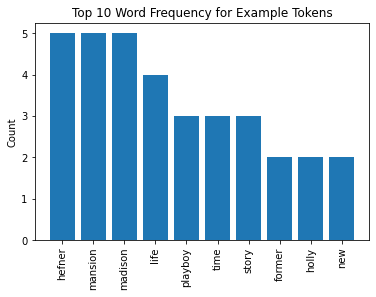

In [75]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(freq_dist, "Top 10 Word Frequency for Example Tokens")

In [76]:
df

,Publication,Content,Bias,num_bias
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,-1
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,-1
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,-1
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,-1
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,-1
...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,1
85361,National Review,Whether it’s celebrated according to the Grego...,Right,1
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,1
85363,National Review,Israel would seem to be in a disastrous positi...,Right,1


In [77]:
#Instaiate needed objects
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords_list
lemma = WordNetLemmatizer()

In [78]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [288]:
pattern = "((@[a-zA-Z0-9_-]+)((?=\s+)|$|[!?.,-]))"
pattern1 =  "((the views expressed by)([\s\S]*)$)"
pattern2 = "((view the discussion thread.)([\s\S]*)$)"
pattern3 = "((pic.)?twitter\.com\/[A-Za-z0-9_]{5,1000}(\?(\w+=\w+&?)*)?)"
pattern4 = "([\d.])"
pattern5 = "(http\S+)"

In [289]:
def preprocess(content):
    #Turn all the tokens lowercase
    content = content.lower()
    #rmove necessary item from content (see above)
    content = re.sub(pattern, " ", str(content))
    content = re.sub(pattern1, " ", str(content))
    content = re.sub(pattern2, " ", str(content))
    content = re.sub(pattern3, " ", str(content))
    content = re.sub(pattern4, " ", str(content))
    content = re.sub(pattern5, " ", str(content))
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(content)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return str(cleaned_string)

In [284]:
df["Content"].iloc[50600]

'Office of Management and Budget Director Mick Mulvaney on Wednesday defended President Trump’s budget proposal to a House panel, arguing its steep cuts were necessary to reduce the country’s deficits. “Great countries are not destroyed from without. They rot from within,” he said to the House Budget Committee. Trump’s plan would balance the budget by 2027 and reduce the national debt to 60 percent of gross domestic product, but Democrats and Republicans alike noted that it relies on optimistic economic growth figures and other budgetary tricks to reach those figures. Democrats homed in on the aggressive cuts to Medicaid, food stamps and Social Security Disability Insurance, among other programs. Rep. John YarmuthJohn Allen YarmuthTrump signs two-year budget deal Lawmakers point to entitlements when asked about deficits House Problem Solvers are bringing real change to Congress MORE (D-Ky.), the House Budget Committee’s ranking member, called it “shockingly extreme, the antithesis of w

In [285]:
#Sanity check on data
preprocess(df["Content"].iloc[50600])

'maybe time life screamed television set flip channel get life ah unless current president united state probably watch way tv see something like flip stew call friend complains tweet act according source knowledge trump told friend increasingly concerned fbi director james comey grown control pursuing agenda comey testimony last week source say pushed edge acted decided fire comey childish impetuous dangerous manner looked rationale found memo written rod rosenstein deputy attorney general white house used cover story vice president trump blown explanation telling nbc would fired comey matter justice official recommended trump lie penny like mike flynn asking credibility lost apparently one able tell newbie behave firing current fbi director middle russia investigation matter tarnished reputation bad idea one tell matter furious investigation growing requiring resource trying kill striking fbi director bad idea might interpreted obstruction justice none matter trump never louise sunshi

In [286]:
df["processed_content"] =  df["Content"].apply(lambda x: preprocess(x))

In [397]:
df

,Publication,Content,Bias,num_bias,processed_content
0,CNN,Istanbul (CNN) At least 39 people were killed ...,Left,0,istanbul least people killed least wounded att...
1,CNN,Atlanta (CNN) This season’s College Football P...,Left,0,atlanta season college football playoff center...
2,CNN,(CNN) Revelers on the United States’ west coa...,Left,0,reveler united state west coast cheered advent...
3,CNN,"West Palm Beach, Florida (CNN) Donald Trump s...",Left,0,west palm beach florida donald trump said satu...
4,CNN,(CNN) Two small planes collided in Texas on S...,Left,0,two small plane collided texas saturday killin...
...,...,...,...,...,...
85360,National Review,I first read Thomas Sowell in college — no ...,Right,2,first read thomas sowell college thanks colleg...
85361,National Review,Whether it’s celebrated according to the Grego...,Right,2,whether celebrated according gregorian julian ...
85362,National Review,Editor’s Note: This piece first appeared in th...,Right,2,editor note piece first appeared april issue n...
85363,National Review,Israel would seem to be in a disastrous positi...,Right,2,israel would seem disastrous position given in...


In [398]:
df.to_pickle("../data/processed.pkl")